<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W3/tutorials/W3D1_RealNeurons/W3D1_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 1, Tutorial 3
# Real Neurons: Synaptic transmission - Models of static and dynamic synapses
__Content creators:__ Qinglong Gu, Songtin Li, John Murray, Richard Naud, Arvind Kumar

__Content reviewers:__  Maryam Vaziri-Pashkam, Ella Batty, Lorenzo Fontolan, Richard Gao, Matthew Krause, Spiros Chavlis, Michael Waskom

---
# Tutorial Objectives
Synapses connect neurons into neural networks or circuits. Specialized electrical synapses make direct, physical connections between neurons. In this tutorial, however, we will focus on **chemical synapses**, which are more common in the brain. These synapses do not physically join neurons. Instead, a spike in the presynaptic cell causes a chemical, or neurotransmitter, to be released into a small space between the neurons called the synaptic cleft. Once the chemical diffuses across that space, it changes the pearmeability of the postsynaptic membrane, which may result in a positive or negative change in the membrane voltage.

In this tutorial, we will model chemical synaptic transmission and study some interesting effects produced by **static synapses** and **dynamic synapses**.

First, we will start by writing code to simulate static synapses -- whose weight is always fixed. 
Next, we will extend the model and model **dynamic synapses** -- whose synaptic strength is dependent on the recent spike history: synapses can either progressively increase or decrease the size of their effects on the post-synaptic neuron, based on the recent firing rate of its presynaptic partners. This feature of synapses in the brain is called **Short-Term Plasticity** and causes synapses to undergo *Facilitation* or *Depression*. 

Our goals for this tutorial are to:

- simulate static synapses and study how excitation and inhibition affect the patterns in the neurons' spiking output
- define mean- or fluctuation-driven regimes
- simulate short-term dynamics of synapses (facilitation and depression)
- study how a change in pre-synaptic firing history affects the synaptic weights (i.e., PSP amplitude)

Video available at https://youtube.com/watch?v=Hbz2lj2AO_0


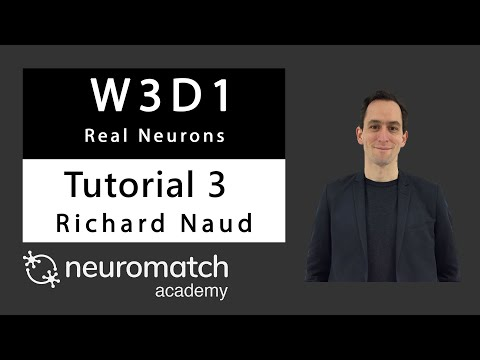

In [1]:
#@title Video 1: Static and dynamic synapses
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='Hbz2lj2AO_0', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---
# Setup


In [2]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format='retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
my_layout = widgets.Layout()

In [4]:
# @title Helper functions


def my_GWN(pars, mu, sig, myseed=False):
  """
  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                  the same seed will give the same random number sequence

  Returns:
    I          : Gaussian White Noise (GWN) input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  # you can fix the seed of the random number generator so that the results
  # are reliable. However, when you want to generate multiple realizations
  # make sure that you change the seed for each new realization.
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate GWN
  # we divide here by 1000 to convert units to seconds.
  I_GWN = mu + sig * np.random.randn(Lt) / np.sqrt(dt / 1000.)

  return I_GWN


def Poisson_generator(pars, rate, n, myseed=False):
  """
  Generates poisson trains

  Args:
    pars       : parameter dictionary
    rate       : noise amplitute [Hz]
    n          : number of Poisson trains
    myseed     : random seed. int or boolean

  Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                      there is a spike in ith spike train over time
                      (1 if spike, 0 otherwise)
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate uniformly distributed random variables
  u_rand = np.random.rand(n, Lt)

  # generate Poisson train
  poisson_train = 1. * (u_rand < rate * (dt / 1000.))

  return poisson_train


def default_pars(**kwargs):
  pars = {}

  ### typical neuron parameters###
  pars['V_th'] = -55.    # spike threshold [mV]
  pars['V_reset'] = -75. # reset potential [mV]
  pars['tau_m'] = 10.    # membrane time constant [ms]
  pars['g_L'] = 10.      # leak conductance [nS]
  pars['V_init'] = -65.  # initial potential [mV]
  pars['E_L'] = -75.     # leak reversal potential [mV]
  pars['tref'] = 2.      # refractory time (ms)

  ### simulation parameters ###
  pars['T'] = 400.  # Total duration of simulation [ms]
  pars['dt'] = .1   # Simulation time step [ms]

  ### external parameters if any ###
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars


def my_illus_LIFSYN(pars, v_fmp, v):
  """
  Illustartion of FMP and membrane voltage

  Args:
    pars  : parameters dictionary
    v_fmp : free membrane potential, mV
    v     : membrane voltage, mV

  Returns:
    plot of membrane voltage and FMP, alongside with the spiking threshold
    and the mean FMP (dashed lines)
  """

  plt.figure(figsize=(14, 5))
  plt.plot(pars['range_t'], v_fmp, 'r', lw=1.,
           label='Free mem. pot.', zorder=2)
  plt.plot(pars['range_t'], v, 'b', lw=1.,
           label='True mem. pot', zorder=1, alpha=0.7)
  plt.axhline(-55, 0, 1, color='k', lw=2., ls='--',
              label='Spike Threshold', zorder=1)
  plt.axhline(np.mean(v_fmp), 0, 1, color='r', lw=2., ls='--',
              label='Mean Free Mem. Pot.', zorder=1)
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(loc=[1.02, 0.68])
  plt.show()


def my_illus_STD(Poi_or_reg=False, rate=20., U0=0.5,
                 tau_d=100., tau_f=50., plot_out=True):
  """
   Only for one presynaptic train

  Args:
    Poi_or_reg : Poisson or regular input spiking trains
    rate       : Rate of input spikes, Hz
    U0         : synaptic release probability at rest
    tau_d      : synaptic depression time constant of x [ms]
    tau_f      : synaptic facilitation time constantr of u [ms]
    plot_out   : whether ot not to plot, True or False

  Returns:
    Nothing.
  """

  T_simu = 10.0 * 1000 / (1.0 * rate)  # 10 spikes in the time window
  pars = default_pars(T=T_simu)
  dt = pars['dt']

  if Poi_or_reg:
    # Poisson type spike train
    pre_spike_train = Poisson_generator(pars, rate, n=1)
    pre_spike_train = pre_spike_train.sum(axis=0)
  else:
    # Regular firing rate
    isi_num = int((1e3/rate)/dt)  # number of dt
    pre_spike_train = np.zeros(len(pars['range_t']))
    pre_spike_train[::isi_num] = 1.

  u, R, g = dynamic_syn(g_bar=1.2, tau_syn=5., U0=U0,
                        tau_d=tau_d, tau_f=tau_f,
                        pre_spike_train=pre_spike_train,
                        dt=pars['dt'])

  if plot_out:
    plt.figure(figsize=(12, 6))

    plt.subplot(221)
    plt.plot(pars['range_t'], R, 'b', label='R')
    plt.plot(pars['range_t'], u, 'r', label='u')
    plt.legend(loc='best')
    plt.xlim((0, pars['T']))
    plt.ylabel(r'$R$ or $u$ (a.u)')
    plt.subplot(223)
    spT = pre_spike_train > 0
    t_sp = pars['range_t'][spT]  #spike times
    plt.plot(t_sp, 0. * np.ones(len(t_sp)), 'k|', ms=18, markeredgewidth=2)
    plt.xlabel('Time (ms)');
    plt.xlim((0, pars['T']))
    plt.yticks([])
    plt.title('Presynaptic spikes')

    plt.subplot(122)
    plt.plot(pars['range_t'], g, 'r', label='STP synapse')
    plt.xlabel('Time (ms)')
    plt.ylabel('g (nS)')
    plt.xlim((0, pars['T']))

    plt.tight_layout()

  if not Poi_or_reg:
    return g[isi_num], g[9*isi_num]


def plot_volt_trace(pars, v, sp):
  """
  Plot trajetory of membrane potential for a single neuron

  Args:
    pars   : parameter dictionary
    v      : volt trajetory
    sp     : spike train

  Returns:
    figure of the membrane potential trajetory for a single neuron
  """

  V_th = pars['V_th']
  dt = pars['dt']
  if sp.size:
      sp_num = (sp/dt).astype(int) - 1
      v[sp_num] += 10

  plt.plot(pars['range_t'], v, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--', lw=1.)
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')

In the `Helper Function`:

- Gaussian white noise generator: `my_GWN(pars, mu, sig, myseed=False)`
- Poissonian spike train generator: `Poisson_generator(pars, rate, n, myseed=False)`
- default parameter function (as before) and other plotting utilities

---
# Section 1: Static synapses

## Section 1.1: Simulate synaptic conductance dynamics

Synaptic input _in vivo_ consists of a mixture of **excitatory** neurotransmitters, which depolarizes the cell and drives it towards spike threshold, and **inhibitory** neurotransmitters that hyperpolarize it, driving it away from spike threshold. These chemicals cause specific ion channels on the postsynaptic neuron to open, resulting in a change in that neuron's conductance and, therefore, the flow of current in or out of the cell.

This process can be modelled by assuming that the presynaptic neuron's spiking activity produces transient changes in the postsynaptic neuron's conductance ($g_{\rm syn}(t)$). Typically, the conductance transient is modeled as an exponential function. 

Such conductance transients can be generated using a simple ordinary differential equation (ODE):

\\

\begin{eqnarray}
\frac{dg_{\rm syn}(t)}{dt} &=& \bar{g}_{\rm syn} \sum_k \delta(t-t_k) -g_{\rm syn}(t)/\tau_{\rm syn}
\end{eqnarray}

\\

where $\bar{g}_{\rm syn}$ (often referred to as synaptic weight) is the maximum conductance elicited by each incoming spike, and $\tau_{\rm syn}$ is the synaptic time constant. Note that the summation runs over all spikes received by the neuron at time $t_k$.

Ohm's law allows us to convert conductance changes to the current as:

\\

\begin{align}
I_{\rm syn}(t) = g_{\rm syn}(t)(V(t)-E_{\rm syn})  \\
\end{align}

\\

The reversal potential $E_{\rm syn}$ determines the direction of current flow and the excitatory or inhibitory nature of the synapse. 

**Thus, incoming spikes are filtered by an exponential-shaped kernel, effectively low-pass filtering the input. In other words, synaptic input is not white noise, but it is, in fact, colored noise, where the color (spectrum) of the noise is determined by the synaptic time constants of both excitatory and inhibitory synapses.**

In a neuronal network, the total synaptic input current $I_{\rm syn}$ is the sum of both excitatory and inhibitory inputs. Assuming the total excitatory and inhibitory conductances received at time $t$ are $g_E(t)$ and $g_I(t)$, and their corresponding reversal potentials are $E_E$ and $E_I$, respectively, then the total synaptic current can be described as: 

\\

\begin{align}
I_{\rm syn}(V(t),t) = -g_E(t) (V-E_E) - g_I(t) (V-E_I)
\end{align}

\\

Accordingly, the membrane potential dynamics of the LIF neuron under synaptic current drive become:

\\

\begin{eqnarray}
\tau_m\frac{dV(t)}{dt} = -(V(t)-E_L) - \frac{g_E(t)}{g_L} (V(t)-E_E) - \frac{g_I(t)}{g_L} (V(t)-E_I) + \frac{I_{\rm inj}}{g_L}\quad (2)
\end{eqnarray}

\\

$I_{\rm inj}$ is an external current injected in the neuron, which is under experimental control; it can be GWN, DC, or anything else.

We will use Eq. (2) to simulate the conductance-based LIF neuron model below.

In the previous tutorials, we saw how the output of a single neuron (spike count/rate and spike time irregularity) changes when we stimulate the neuron with DC and GWN, respectively. Now, we are in a position to study how the neuron behaves when it is bombarded with both excitatory and inhibitory spikes trains -- as happens *in vivo*.

What kind of input is a neuron receiving? When we do not know, we chose the simplest option. The simplest model of input spikes is given when every input spike arrives independently of other spikes, i.e., we assume that the input is Poissonian.

## Section 1.2: Simulate LIF neuron with conductance-based synapses

We are now ready to simulate a LIF neuron with conductance-based synaptic inputs! The following code defines the LIF neuron with synaptic input modeled as conductance transients.

In [5]:
# @markdown Execute this cell to get a function for conductance-based LIF neuron (run_LIF_cond)

def run_LIF_cond(pars, I_inj, pre_spike_train_ex, pre_spike_train_in):
  """
  Conductance-based LIF dynamics

  Args:
    pars               : parameter dictionary
    I_inj              : injected current [pA]. The injected current here
                         can be a value or an array
    pre_spike_train_ex : spike train input from presynaptic excitatory neuron
    pre_spike_train_in : spike train input from presynaptic inhibitory neuron

  Returns:
    rec_spikes         : spike times
    rec_v              : mebrane potential
    gE                 : postsynaptic excitatory conductance
    gI                 : postsynaptic inhibitory conductance

  """

  # Retrieve parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  gE_bar, gI_bar = pars['gE_bar'], pars['gI_bar']
  VE, VI = pars['VE'], pars['VI']
  tau_syn_E, tau_syn_I = pars['tau_syn_E'], pars['tau_syn_I']
  tref = pars['tref']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Initialize
  tr = 0.
  v = np.zeros(Lt)
  v[0] = V_init
  gE = np.zeros(Lt)
  gI = np.zeros(Lt)
  Iinj = I_inj * np.ones(Lt)  # ensure Iinj has length Lt

  if pre_spike_train_ex.max() == 0:
    pre_spike_train_ex_total = np.zeros(Lt)
  else:
    pre_spike_train_ex_total = pre_spike_train_ex.sum(axis=0) * np.ones(Lt)

  if pre_spike_train_in.max() == 0:
    pre_spike_train_in_total = np.zeros(Lt)
  else:
    pre_spike_train_in_total = pre_spike_train_in.sum(axis=0) * np.ones(Lt)

  # simulation
  rec_spikes = []  # recording spike times
  for it in range(Lt - 1):
    if tr > 0:
      v[it] = V_reset
      tr = tr - 1
    elif v[it] >= V_th:  # reset voltage and record spike event
      rec_spikes.append(it)
      v[it] = V_reset
      tr = tref / dt

    # update the synaptic conductance
    gE[it + 1] = gE[it] - (dt / tau_syn_E) * gE[it] + gE_bar * pre_spike_train_ex_total[it + 1]
    gI[it + 1] = gI[it] - (dt / tau_syn_I) * gI[it] + gI_bar * pre_spike_train_in_total[it + 1]

    # calculate the increment of the membrane potential
    dv = (dt / tau_m) * (-(v[it] - E_L) \
                         - (gE[it + 1] / g_L) * (v[it] - VE) \
                         - (gI[it + 1] / g_L) * (v[it] - VI) + Iinj[it] / g_L)

    # update membrane potential
    v[it+1] = v[it] + dv

  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes, gE, gI


print(help(run_LIF_cond))

Help on function run_LIF_cond in module __main__:

run_LIF_cond(pars, I_inj, pre_spike_train_ex, pre_spike_train_in)
    Conductance-based LIF dynamics
    
    Args:
      pars               : parameter dictionary
      I_inj              : injected current [pA]. The injected current here
                           can be a value or an array
      pre_spike_train_ex : spike train input from presynaptic excitatory neuron
      pre_spike_train_in : spike train input from presynaptic inhibitory neuron
    
    Returns:
      rec_spikes         : spike times
      rec_v              : mebrane potential
      gE                 : postsynaptic excitatory conductance
      gI                 : postsynaptic inhibitory conductance

None


### Exercise 1: Measure the mean free membrane potential

Let's simulate the conductance-based LIF neuron with presynaptic spike trains generated by a `Poisson_generator` with rate 10 Hz for both excitatory and inhibitory inputs. Here, we choose 80 excitatory presynaptic spike trains and 20 inhibitory ones.

Previously, we've already learned that $CV_{\rm ISI}$ can describe the irregularity of the output spike pattern. Now, we will introduce a new descriptor of the neuron membrane, i.e., the  **Free Membrane Potential (FMP)** -- the membrane potential of the neuron when its spike threshold is removed. 

Although this is completely artificial, calculating this quantity allows us to get an idea of how strong the input is. We are mostly interested in knowing the mean and standard deviation (std.) of the FMP. In the exercise, you can visualize the FMP and membrane voltage with spike threshold.

In [6]:
# To complete the exercise, uncomment the code and fill the missing parts (...)
pars = default_pars(T=1000.)
# Add parameters
pars['gE_bar'] = 2.4    # [nS]
pars['VE'] = 0.         # [mV] excitatory reversal potential
pars['tau_syn_E'] = 2.  # [ms]
pars['gI_bar'] = 2.4    # [nS]
pars['VI'] = -80.       # [mV] inhibitory reversal potential
pars['tau_syn_I'] = 5.  # [ms]

# generate presynaptic spike trains
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=80)
pre_spike_train_in = Poisson_generator(pars, rate=10, n=20)

# simulate conductance-based LIF model
v, rec_spikes, gE, gI = run_LIF_cond(pars, 0, pre_spike_train_ex,
                                     pre_spike_train_in)
dt, range_t = pars['dt'], pars['range_t']
if rec_spikes.size:
  sp_num = (rec_spikes / dt).astype(int) - 1
  v[sp_num] = 10   # draw nicer spikes

####################################################################
## TODO for students: measure the free membrane potential
# In order to measure the free membrane potential, first,
# you should prevent the firing of the LIF neuron
# How to prevent a LIF neuron from firing? Increse the threshold pars['V_th'].
####################################################################
# Change the threshold
# pars['V_th'] = ...
# Calculate FMP
# v_fmp, _, _, _ = run_LIF_cond(pars, ..., ..., ...)

# uncomment when you have filled the exercise
# my_illus_LIFSYN(pars, v_fmp, v)

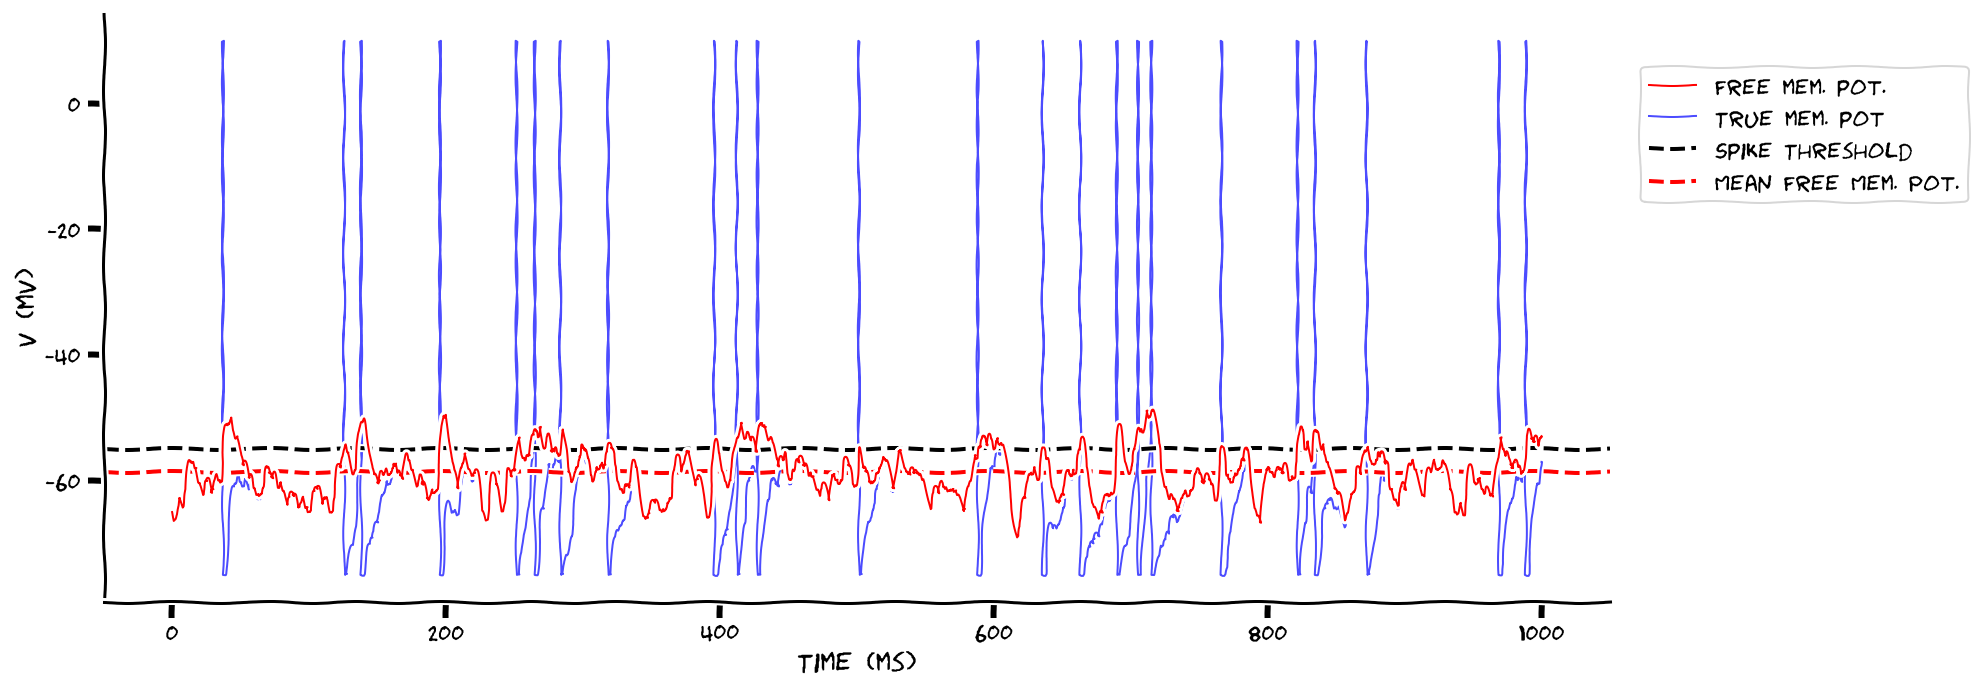

In [7]:
# to_remove solution
pars = default_pars(T=1000.)
# Add parameters
pars['gE_bar'] = 2.4    # [nS]
pars['VE'] = 0.         # [mV] excitatory reversal potential
pars['tau_syn_E'] = 2.  # [ms]
pars['gI_bar'] = 2.4    # [nS]
pars['VI'] = -80.       # [mV] inhibitory reversal potential
pars['tau_syn_I'] = 5.  # [ms]

# generate presynaptic spike trains
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=80)
pre_spike_train_in = Poisson_generator(pars, rate=10, n=20)

# simulate conductance-based LIF model
v, rec_spikes, gE, gI = run_LIF_cond(pars, 0, pre_spike_train_ex,
                                     pre_spike_train_in)
dt, range_t = pars['dt'], pars['range_t']
if rec_spikes.size:
  sp_num = (rec_spikes / dt).astype(int) - 1
  v[sp_num] = 10   # draw nicer spikes

# Change the threshold
pars['V_th'] = 1e3
# Calculate FMP
v_fmp, _, _, _ = run_LIF_cond(pars, 0, pre_spike_train_ex, pre_spike_train_in)

with plt.xkcd():
  my_illus_LIFSYN(pars, v_fmp, v)

### Interactive Demo: Conductance-based LIF Explorer with different E/I input

In the following, we can investigate how varying the ratio of excitatory to inhibitory inputs changes the firing rate and the spike time regularity (see the output text). 

To change both the excitatory and inhibitory inputs, we will vary their firing rates. *However, if you wish, you can vary the strength and/or the number of these connections as well.*  

Pay close attention to the mean free membrane potential (red dotted line) and its location with respect to the spike threshold (black dotted line). Try to develop a heuristic about the mean of the FMP and spike time irregularity ($CV_{\rm ISI}$)

In [8]:
# @title

# @markdown Make sure you execute this cell to enable the widget!

my_layout.width = '450px'
@widgets.interact(
    inh_rate=widgets.FloatSlider(20., min=10., max=60., step=5.,
                                 layout=my_layout),
    exc_rate=widgets.FloatSlider(10., min=2., max=20., step=2.,
                                 layout=my_layout)
)


def EI_isi_regularity(exc_rate, inh_rate):

  pars = default_pars(T=1000.)
  # Add parameters
  pars['gE_bar'] = 3.     # [nS]
  pars['VE'] = 0.         # [mV] excitatory reversal potential
  pars['tau_syn_E'] = 2.  # [ms]
  pars['gI_bar'] = 3.     # [nS]
  pars['VI'] = -80.       # [mV] inhibitory reversal potential
  pars['tau_syn_I'] = 5.  # [ms]

  pre_spike_train_ex = Poisson_generator(pars, rate=exc_rate, n=80)
  pre_spike_train_in = Poisson_generator(pars, rate=inh_rate, n=20)  # 4:1

  # Lets first simulate a neuron with identical input but with no spike
  # threshold by setting the threshold to a very high value
  # so that we can look at the free membrane potential
  pars['V_th'] = 1e3
  v_fmp, rec_spikes, gE, gI = run_LIF_cond(pars, 0, pre_spike_train_ex,
                                           pre_spike_train_in)

  # Now simulate a LIP with a regular spike threshold
  pars['V_th'] = -55.
  v, rec_spikes, gE, gI = run_LIF_cond(pars, 0, pre_spike_train_ex,
                                       pre_spike_train_in)
  dt, range_t = pars['dt'], pars['range_t']
  if rec_spikes.size:
      sp_num = (rec_spikes / dt).astype(int) - 1
      v[sp_num] = 10  # draw nicer spikes

  spike_rate = 1e3 * len(rec_spikes) / pars['T']

  cv_isi = 0.
  if len(rec_spikes) > 3:
    isi = np.diff(rec_spikes)
    cv_isi = np.std(isi) / np.mean(isi)

  print('\n')
  plt.figure(figsize=(15, 10))
  plt.subplot(211)
  plt.text(500, -35, f'Spike rate = {spike_rate:.3f} (sp/s), Mean of Free Mem Pot = {np.mean(v_fmp):.3f}',
           fontsize=16, fontweight='bold', horizontalalignment='center',
           verticalalignment='bottom')
  plt.text(500, -38.5, f'CV ISI = {cv_isi:.3f}, STD of Free Mem Pot = {np.std(v_fmp):.3f}',
           fontsize=16, fontweight='bold', horizontalalignment='center',
           verticalalignment='bottom')

  plt.plot(pars['range_t'], v_fmp, 'r', lw=1.,
           label='Free mem. pot.', zorder=2)
  plt.plot(pars['range_t'], v, 'b', lw=1.,
           label='mem. pot with spk thr', zorder=1, alpha=0.7)
  plt.axhline(pars['V_th'], 0, 1, color='k', lw=1., ls='--',
              label='Spike Threshold', zorder=1)
  plt.axhline(np.mean(v_fmp),0, 1, color='r', lw=1., ls='--',
              label='Mean Free Mem. Pot.', zorder=1)
  plt.ylim(-76, -39)
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(loc=[1.02, 0.68])

  plt.subplot(223)
  plt.plot(pars['range_t'][::3], gE[::3], 'r', lw=1)
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$g_E$ (nS)')

  plt.subplot(224)
  plt.plot(pars['range_t'][::3], gI[::3], 'b', lw=1)
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$g_I$ (nS)')

  plt.tight_layout()

interactive(children=(FloatSlider(value=10.0, description='exc_rate', layout=Layout(width='450px'), max=20.0, …

**Mean-driven and Fluctuation-driven regimes**

If we look at the figure above, we note that when the mean FMP is above spike threshold, the fluctuations in the FMP are rather small, and the neuron spikes in a fairly regular fashion. This regime, where the mean FMP is above the spike threshold, is called **mean-driven regime**. 


When the mean FMP is below the spike threshold, the fluctuations in the FMP are large, and the neuron's spikes are driven by these fluctuations. As a consequence, the neuron spikes in more  Poisson-like fashion. This regime, where the mean FMP is below the spike threshold, and spikes are driven by the fluctuations, is called **fluctuation-driven regime**. 

## Think!

- How much can you increase the spike pattern variability? Under what condition(s) might the neuron respond with Poisson-type spikes? Note that we injected Poisson-type spikes. (Think of the answer in terms of the ratio of the exc. and inh. input spike rates.)

- Link to the balance of excitation and inhibition: one of the definitions of excitation and inhibition balance is that mean free membrane potential remains constant as excitatory and inhibitory input rates are increased. What do you think happens to the neuron firing rate as we change excitatory and inhibitory rates while keeping the neuron in balance?  See [Kuhn, Aertsen, and Rotter (2004)](https://www.jneurosci.org/content/jneuro/24/10/2345.full.pdf) for much more on this.

In [9]:
# to_remove explanation

"""
Discussion:

1. We can push the neuron to spike almost like a Poisson neuron. Of course given
that there is a refractoriness it will never spike completely like a Poisson process.
Poisson type spike irregularity will be achieved when mean is small (far from the
spike threshold) and fluctuations are large. This will achieved when excitatory
and inhibitory rates are balanced -- i.e. ratio of exc and inh. spike rate is
constant as you vary the inout rate.

2. Firing rate will increase because fluctuations will increase as we increase
exc. and inh. rates. But if synapses are modelled as conductance as opposed to
currents, fluctuations may start decrease at high input rates because neuron time
constant will drop.

""";

---
# Section 2: Short-term synaptic plasticity
Above, we modeled synapses with fixed weights. Now we will explore synapses whose weight change in some input conditions. 

Short-term plasticity (STP) is a phenomenon in which synaptic efficacy changes over time in a way that reflects the history of presynaptic activity. Two types of STP, with opposite effects on synaptic efficacy, have been experimentally observed. They are known as Short-Term Depression (STD) and Short-Term Facilitation (STF).

The mathematical model (_for more information see [here](http://www.scholarpedia.org/article/Short-term_synaptic_plasticity)_) of STP is based on the concept of a limited pool of synaptic resources available for transmission ($R$), such as, for example, the overall amount of synaptic vesicles at the presynaptic terminals. The amount of presynaptic resource changes in a dynamic fashion depending on the recent history of spikes. 

Following a presynaptic spike, (i) the fraction $u$ (release probability) of the available pool to be utilized increases due to spike-induced calcium influx to the presynaptic terminal, after which (ii) $u$ is consumed to increase the post-synaptic conductance. Between spikes, $u$ decays back to zero with time constant $\tau_f$ and $R$ recovers to 1 with time constant $\tau_d$. In summary, the dynamics of excitatory (subscript $E$) STP are given by:

\\

\begin{eqnarray}
&& \frac{du_E}{dt} &=& -\frac{u_E}{\tau_f} + U_0(1-u_E^-)\delta(t-t_{\rm sp}) \\[.5mm]
&& \frac{dR_E}{dt} &=& \frac{1-R_E}{\tau_d} - u_E^+ R_E^- \delta(t-t_{\rm sp}) \qquad (6) \\[.5mm]    
&& \frac{dg_E(t)}{dt} &=& -\frac{g_E}{\tau_E} + \bar{g}_E u_E^+ R_E^- \delta(t-t_{\rm sp})
\end{eqnarray}

\\

where $U_0$ is a constant determining the increment of $u$ produced by a spike. $u_E^-$ and $R_E^-$ denote the corresponding values just before the spike arrives, whereas $u_E^+$ refers to the moment right after the spike. $\bar{g}_E$ denotes the maximum excitatory conductane, and $g_E(t)$ is calculated for all spiketimes $k$, and decays over time with a time constant $\tau_{E}$. Similarly, one can obtain the dynamics of inhibitory STP (i.e., by replacing the subscript $E$ with $I$).


The interplay between the dynamics of $u$ and $R$ determines whether the joint effect of $uR$ is dominated by *depression* or *facilitation*. In the parameter regime of $\tau_d \gg \tau_f$  and for large $U_0$, an initial spike incurs a large drop in $R$ that takes a long time to recover; therefore, the synapse is STD-dominated. In the regime of $\tau_d \ll \tau_f$ and for small $U_0$, the synaptic efficacy is increased gradually by spikes, and consequently, the synapse is STF-dominated. This phenomenological model successfully reproduces the kinetic dynamics of depressed and facilitated synapses observed in many cortical areas.

## Exercise 2: Compute $du$, $dR$ and $dg$

As we learned in several previous tutorials, the Euler numerical integration method involves the calculation of each derivative at step $n$:

\\

\begin{eqnarray}
du_E &=& -\frac{u_E[t]}{\tau_f} dt + U_0(1-u_E[t])\cdot \text{sp_or_not[t+dt]} \\
dR_E &=& \frac{1-R_E[t]}{\tau_d} dt - u_E[t+dt]R_E[t]\cdot \text{sp_or_not[t+dt]} \\
dg_E &=& -\frac{g_E[t]}{\tau_{E}} dt + \bar{g}_Eu_E[t+dt]R_E[t]\cdot \text{sp_or_not[t+dt]} \\
\end{eqnarray}

\\

where $\text{sp_or_not}=1$ if there's a spike in the time window $dt$, and $\text{sp_or_not}=0$  otherwise. In addition, note that any spike train generated by our `Poisson_generator` is binary. Then, the values are updated:

\\

\begin{eqnarray}
  u_E[t+dt] &=& u_E[t] + du_E \\
  R_E[t+dt] &=& R_E[t] + dR_E \\
  g_E[t+dt] &=& g_E[t] + dg_E \\
\end{eqnarray}

\\

Similarly, one can obtain the dynamics of inhibitory conductance.


In [10]:
def dynamic_syn(g_bar, tau_syn, U0, tau_d, tau_f, pre_spike_train, dt):
  """
  Short-term synaptic plasticity

  Args:
    g_bar           : synaptic conductance strength
    tau_syn         : synaptic time constant [ms]
    U0              : synaptic release probability at rest
    tau_d           : synaptic depression time constant of x [ms]
    tau_f           : synaptic facilitation time constantr of u [ms]
    pre_spike_train : total spike train (number) input
                      from presynaptic neuron
    dt              : time step [ms]

  Returns:
    u               : usage of releasable neurotransmitter
    R               : fraction of synaptic neurotransmitter resources available
    g               : postsynaptic conductance

  """

  Lt = len(pre_spike_train)
  # Initialize
  u = np.zeros(Lt)
  R = np.zeros(Lt)
  R[0] = 1.
  g = np.zeros(Lt)

  # simulation
  for it in range(Lt - 1):

    #########################################################################
    ## TODO for students: compute du, dx and dg, remove NotImplementedError #
    # Note pre_spike_train[i] is binary, i.e., sp_or_not in the i-th timebin
    # Fill out function and remove
    raise NotImplementedError("Student excercise: compute the STP dynamics")
    #########################################################################
    # Compute du
    du = ...
    u[it + 1] = u[it] + du
    # Compute dR
    dR = ...
    R[it + 1] = R[it] + dR
    # Compute dg
    dg = ...
    g[it + 1] = g[it] + dg

  return u, R, g


# Uncomment this line after completing the dynamic_syn function
# _ = my_illus_STD(Poi_or_reg=False, rate=20., U0=0.5, tau_d=100., tau_f=50.)

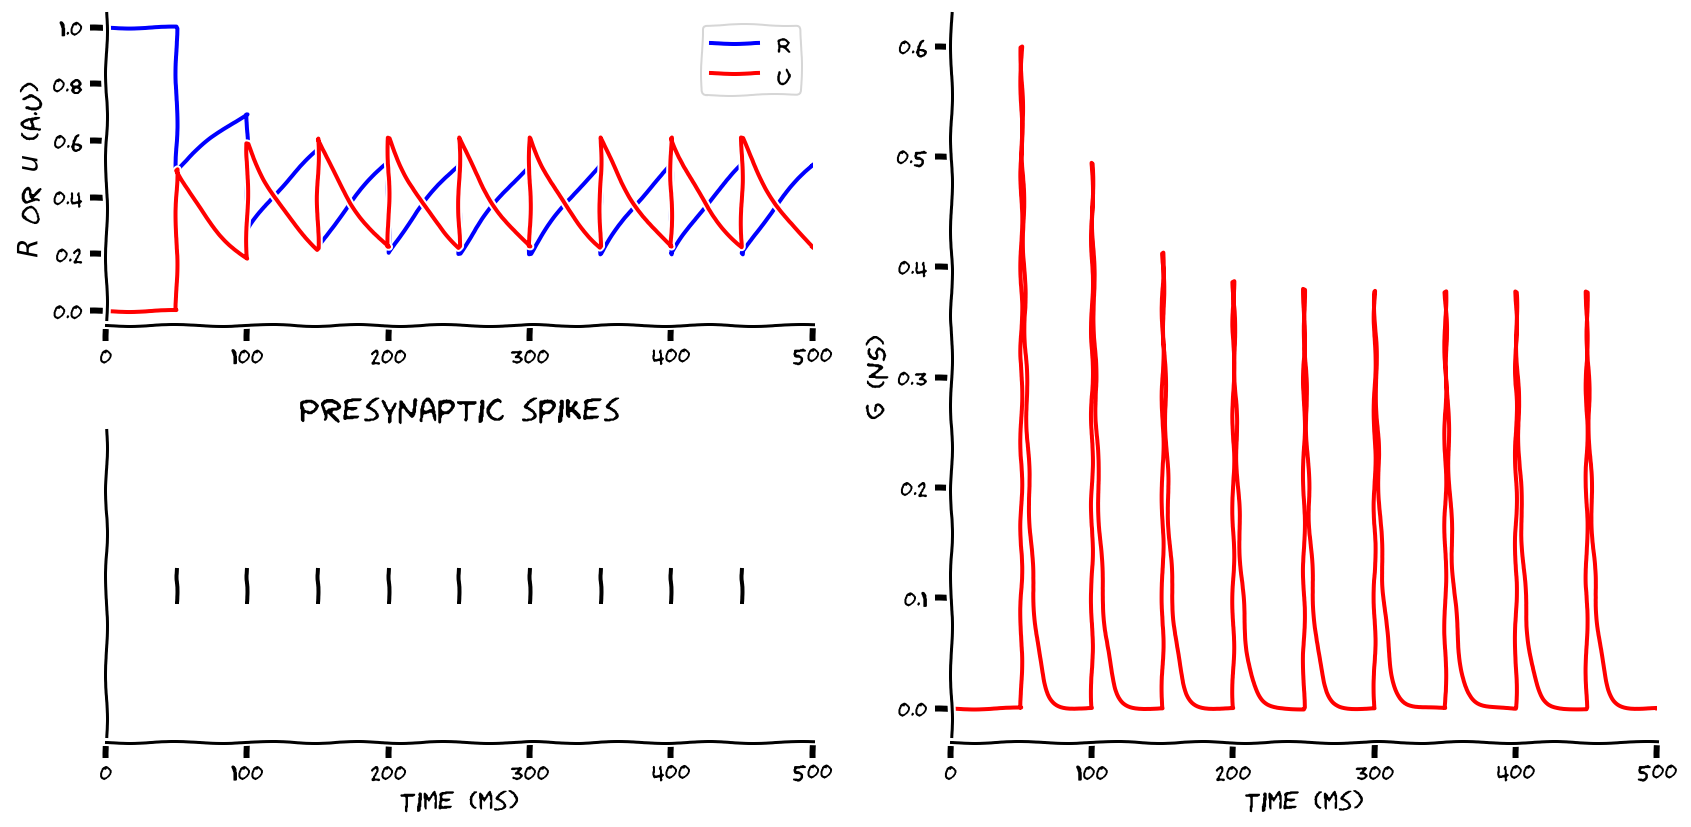

In [11]:
# to_remove solution
def dynamic_syn(g_bar, tau_syn, U0, tau_d, tau_f, pre_spike_train, dt):
  """
  Short-term synaptic plasticity

  Args:
    g_bar           : synaptic conductance strength
    tau_syn         : synaptic time constant [ms]
    U0              : synaptic release probability at rest
    tau_d           : synaptic depression time constant of x [ms]
    tau_f           : synaptic facilitation time constantr of u [ms]
    pre_spike_train : total spike train (number) input
                      from presynaptic neuron
    dt              : time step [ms]

  Returns:
    u               : usage of releasable neurotransmitter
    R               : fraction of synaptic neurotransmitter resources available
    g               : postsynaptic conductance

  """

  Lt = len(pre_spike_train)
  # Initialize
  u = np.zeros(Lt)
  R = np.zeros(Lt)
  R[0] = 1.
  g = np.zeros(Lt)

  # simulation
  for it in range(Lt - 1):
    # Compute du
    du = -(dt / tau_f) * u[it] + U0 * (1.0 - u[it]) * pre_spike_train[it + 1]
    u[it + 1] = u[it] + du
    # Compute dR
    dR = (dt / tau_d) * (1.0 - R[it]) - u[it + 1] * R[it] * pre_spike_train[it + 1]
    R[it + 1] = R[it] + dR
    # Compute dg
    dg = -(dt / tau_syn) * g[it] + g_bar * R[it] * u[it + 1] * pre_spike_train[it + 1]
    g[it + 1] = g[it] + dg

  return u, R, g


with plt.xkcd():
  _ = my_illus_STD(Poi_or_reg=False, rate=20., U0=0.5, tau_d=100., tau_f=50.)

## Section 2.1: Short-term syaptic depression (STD)


### Interactive Demo: STD Explorer with input rate
Below, an interactive demo that shows how Short-term synaptic depression (STD) changes for different firing rates of the presynaptic spike train and how the amplitude synaptic conductance $g$ changes with every incoming spike until it reaches its stationary state.

Does it matter if the neuron fires in a Poisson manner, rather than regularly?

**Note:** `Poi_or_Reg=1`: for *Posisson type* and `Poi_or_Reg=0`: for *regular* presynaptic spikes.

In [12]:
#@title

#@markdown Make sure you execute this cell to enable the widget!


def my_STD_diff_rate(rate, Poi_or_Reg):
      _ = my_illus_STD(Poi_or_reg=Poi_or_Reg, rate=rate)


_ = widgets.interact(my_STD_diff_rate, rate=(10., 100.1, 5.),
                     Poi_or_Reg=(0, 1, 1))

interactive(children=(FloatSlider(value=55.0, description='rate', max=100.1, min=10.0, step=5.0), IntSlider(va…

In [13]:
# to_remove explanation

"""
Discussion:

Increasing the input rate, we decrease the synaptic efficacy, i.e., the synaptic
conductance decreases. This is the case for both Poisson or a regular spiking input.
In case of regular spiking, the synaptic conductance reaches a steady state. This
will not happen in the case of Poisson type spikes.
""";

### Synaptic depression and presynaptic firing rate
Once, I asked an experimentalist about the experimental values of the PSP amplitude produced by a connection between two neocortical excitatory neurons. She asked: "At what frequency?" I was confused, but you will understand her question, now that you know that PSP amplitude depends on the spike history, and therefore on the spike rate of the presynaptic neuron. 

Here, we will study how the ratio of the synaptic conductance corresponding to the first and 10th spikes change as a function of the presynaptic firing rate (experimentalists often take the ratio of first and second PSPs). 

For computational efficiency, we assume that the presynaptic spikes are regular. This assumption means that we do not have to run multiple trials. 

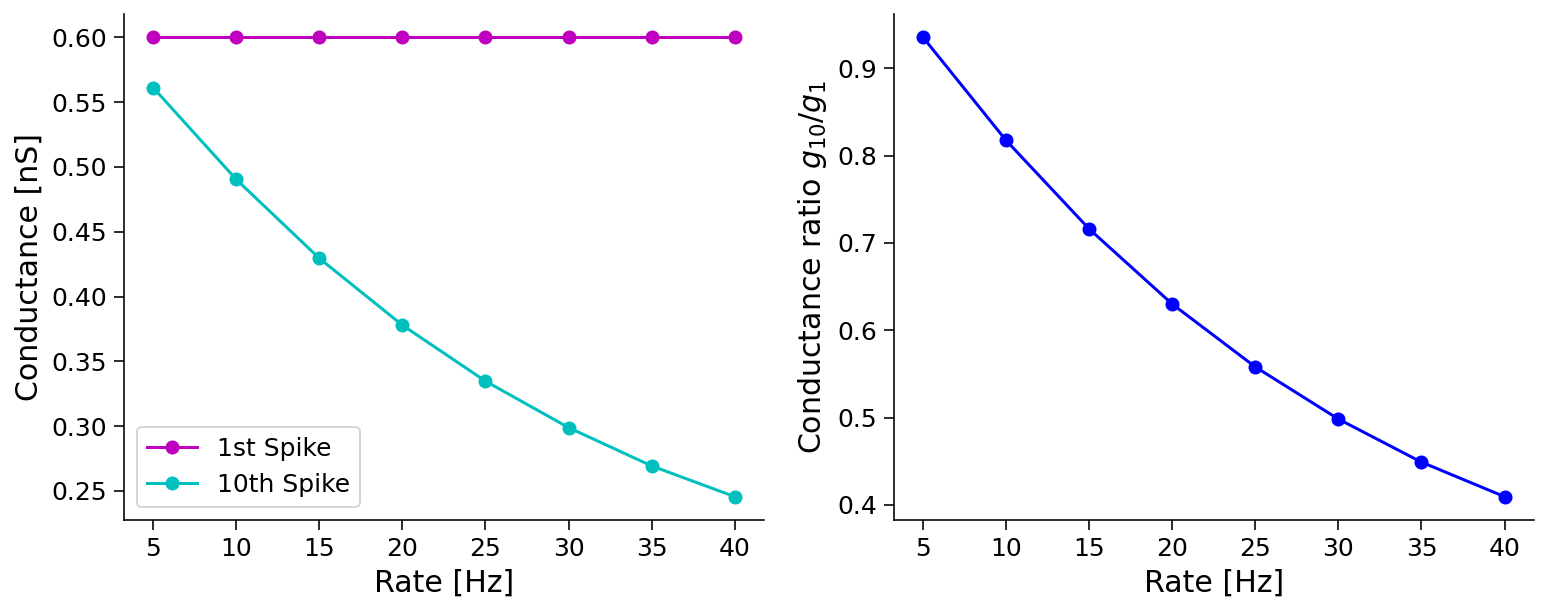

In [14]:
# @markdown STD conductance ratio with different input rate
# Regular firing rate
input_rate = np.arange(5., 40.1, 5.)
g_1 = np.zeros(len(input_rate))  # record the the PSP at 1st spike
g_2 = np.zeros(len(input_rate))  # record the the PSP at 10th spike

for ii in range(len(input_rate)):
   g_1[ii], g_2[ii] = my_illus_STD(Poi_or_reg=False, rate=input_rate[ii],
                                   plot_out=False, U0=0.5, tau_d=100., tau_f=50)

plt.figure(figsize=(11, 4.5))

plt.subplot(121)
plt.plot(input_rate, g_1, 'm-o', label='1st Spike')
plt.plot(input_rate, g_2, 'c-o', label='10th Spike')
plt.xlabel('Rate [Hz]')
plt.ylabel('Conductance [nS]')
plt.legend()

plt.subplot(122)
plt.plot(input_rate, g_2 / g_1, 'b-o')
plt.xlabel('Rate [Hz]')
plt.ylabel(r'Conductance ratio $g_{10}/g_{1}$')
plt.tight_layout()

As we increase the input rate the ratio of the first to tenth spike is increased, because the tenth spike conductance becomes smaller. This is a clear evidence of synaptic depression, as using the same amount of current has a smaller effect on the neuron.

## Section 2.2: Short-term synaptic facilitation (STF)

### Interactive Demo: STF explorer with input rate
Below, we see an illustration of a short-term facilitation example. Take note of the change in the synaptic variables: `U_0`, `tau_d`, and  `tau_f`.

- for STD, `U0=0.5, tau_d=100., tau_f=50.`

- for STP, `U0=0.2, tau_d=100., tau_f=750.`
 
How does the synaptic conductance change as we change the input rate? What do you observe in the case of a regular input and a Poisson type one? 

In [15]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def my_STD_diff_rate(rate, Poi_or_Reg):
  _ = my_illus_STD(Poi_or_reg=Poi_or_Reg, rate=rate, U0=0.2, tau_d=100., tau_f=750.)


_ = widgets.interact(my_STD_diff_rate, rate=(4., 40.1, 2.),
                     Poi_or_Reg=(0, 1, 1))

interactive(children=(FloatSlider(value=22.0, description='rate', max=40.1, min=4.0, step=2.0), IntSlider(valu…

### Synaptic facilitation and presynaptic firing rate

Here, we will study how the ratio of the synaptic conductance corresponding to the $1^{st}$ and $10^{th}$ spike changes as a function of the presynaptic rate. 

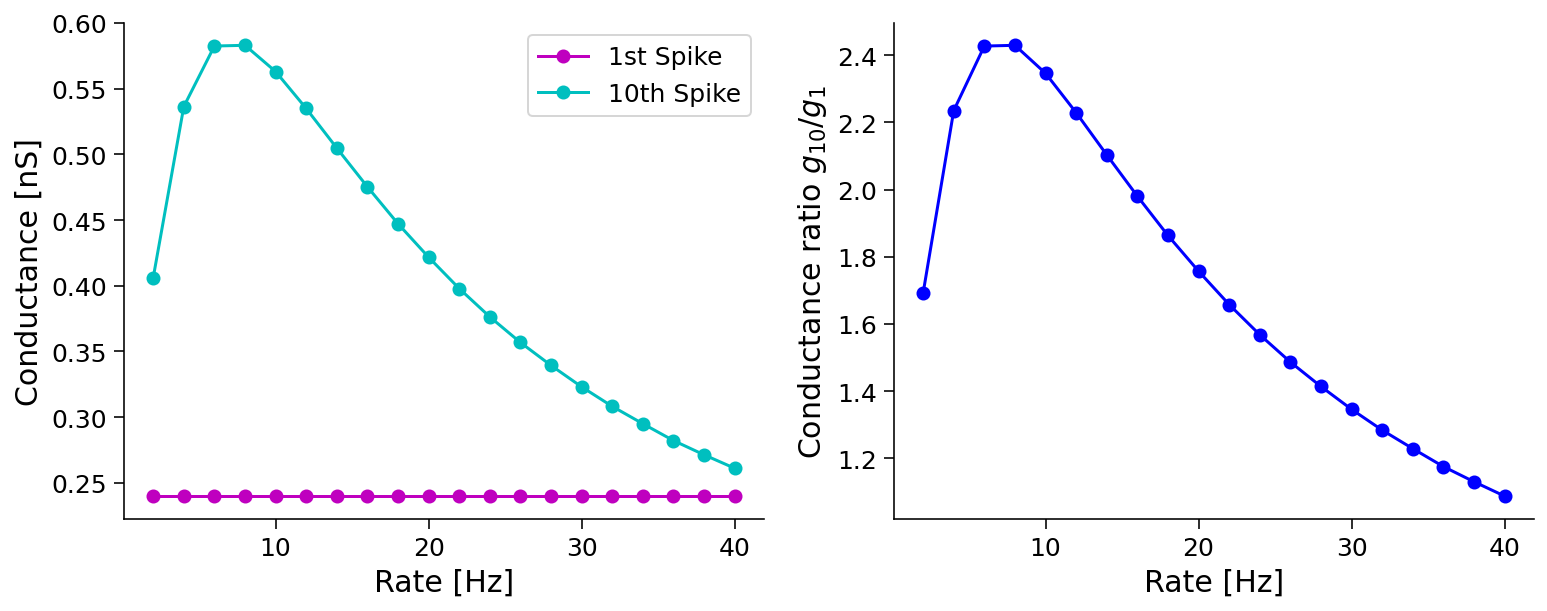

In [16]:
# @title STF conductance ratio with different input rates
# Regular firing rate
input_rate = np.arange(2., 40.1, 2.)
g_1 = np.zeros(len(input_rate))  # record the the PSP at 1st spike
g_2 = np.zeros(len(input_rate))  # record the the PSP at 10th spike

for ii in range(len(input_rate)):
   g_1[ii], g_2[ii] = my_illus_STD(Poi_or_reg=False, rate=input_rate[ii],
                                   plot_out=False,
                                   U0=0.2, tau_d=100., tau_f=750.)

plt.figure(figsize=(11, 4.5))

plt.subplot(121)
plt.plot(input_rate, g_1, 'm-o', label='1st Spike')
plt.plot(input_rate, g_2, 'c-o', label='10th Spike')
plt.xlabel('Rate [Hz]')
plt.ylabel('Conductance [nS]')
plt.legend()

plt.subplot(122)
plt.plot(input_rate, g_2 / g_1, 'b-o',)
plt.xlabel('Rate [Hz]')
plt.ylabel(r'Conductance ratio $g_{10}/g_{1}$')
plt.tight_layout()

## Think!

Why does the ratio of the first and tenth spike conductance changes in a non-monotonic fashion for synapses with STF, even though it decreases monotonically for synapses with STD?

In [17]:
# to_remove explanation

"""
Discussion:

Because we have a facilitatory synapses, as the input rate increases synaptic
resources released per spike also increase. Therefore, we expect that the synaptic
conductance will increase with input rate. However, total synaptic resources are
finite. And they recover in a finite time. Therefore, at high frequency inputs
synaptic resources are rapidly deleted at a higher rate than their recovery, so
after first few spikes, only a small number of synaptic resources are left. This
results in decrease in the steady-state synaptic conductance at high frequency inputs.
""";

---
# Summary

Congratulations! You have just finished the last tutorial of this day. Here, we saw how to model conductance-based synapses and also how to incorporate short-term dynamics in synaptic weights. 

We covered the:

- static synapses and how excitation and inhibition affect the neuronal output
- mean- or fluctuation-driven regimes
- short-term dynamics of synapses (both facilitation and depression)

Finally, we incorporated all the aforementioned tools to study how a change in presynaptic firing history affects the synaptic weights!

There are many interesting things that you can try on your own to develop a deeper understanding of biological synapses. A couple of those are mentioned below in the optional boxes -- if you have time.

But now it is time to explore another important feature of biological synapses, i.e., spike timing dependent synaptic plasticity (go to the next tutorial).

---
# Bonus 1: Conductance-based LIF with STP


Previously, we looked only at how the presynaptic firing rate affects the presynaptic resource availability and thereby the synaptic conductance. It is straightforward to imagine that, while the synaptic conductances are changing, the output of the postsynaptic neuron will change as well. 

So, let's put the STP on synapses impinging on an LIF neuron and see what happens. 

In [18]:
# @title Function for conductance-based LIF neuron with STP-synapses

def run_LIF_cond_STP(pars, I_inj, pre_spike_train_ex, pre_spike_train_in):
  """
  conductance-based LIF dynamics

  Args:
    pars               : parameter dictionary
    I_inj              : injected current [pA]
                         The injected current here can be a value or an array
    pre_spike_train_ex : spike train input from presynaptic excitatory neuron (binary)
    pre_spike_train_in : spike train input from presynaptic inhibitory neuron (binary)

  Returns:
    rec_spikes : spike times
    rec_v      : mebrane potential
    gE         : postsynaptic excitatory conductance
    gI         : postsynaptic inhibitory conductance

  """

  # Retrieve parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, V_L = pars['V_init'], pars['E_L']
  gE_bar, gI_bar = pars['gE_bar'], pars['gI_bar']
  U0E, tau_dE, tau_fE = pars['U0_E'], pars['tau_d_E'], pars['tau_f_E']
  U0I, tau_dI, tau_fI = pars['U0_I'], pars['tau_d_I'], pars['tau_f_I']
  VE, VI = pars['VE'], pars['VI']
  tau_syn_E, tau_syn_I = pars['tau_syn_E'], pars['tau_syn_I']
  tref = pars['tref']

  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  nE = pre_spike_train_ex.shape[0]
  nI = pre_spike_train_in.shape[0]

  # compute conductance Excitatory synapses
  uE = np.zeros((nE, Lt))
  RE = np.zeros((nE, Lt))
  gE = np.zeros((nE, Lt))
  for ie in range(nE):
    u, R, g = dynamic_syn(gE_bar, tau_syn_E, U0E, tau_dE, tau_fE,
                          pre_spike_train_ex[ie, :], dt)

    uE[ie, :], RE[ie, :], gE[ie, :] = u, R, g

  gE_total = gE.sum(axis=0)

  # compute conductance Inhibitory synapses
  uI = np.zeros((nI, Lt))
  RI = np.zeros((nI, Lt))
  gI = np.zeros((nI, Lt))
  for ii in range(nI):
    u, R, g = dynamic_syn(gI_bar, tau_syn_I, U0I, tau_dI, tau_fI,
                          pre_spike_train_in[ii, :], dt)

    uI[ii, :], RI[ii, :], gI[ii, :] = u, R, g

  gI_total = gI.sum(axis=0)

  # Initialize
  v = np.zeros(Lt)
  v[0] = V_init
  Iinj = I_inj * np.ones(Lt)  # ensure I has length Lt

  # simulation
  rec_spikes = []  # recording spike times
  tr = 0.
  for it in range(Lt - 1):
    if tr > 0:
      v[it] = V_reset
      tr = tr - 1
    elif v[it] >= V_th:  # reset voltage and record spike event
      rec_spikes.append(it)
      v[it] = V_reset
      tr = tref / dt

    # calculate the increment of the membrane potential
    dv = (dt / tau_m) * (-(v[it] - V_L) \
                         - (gE_total[it + 1] / g_L) * (v[it] - VE) \
                         - (gI_total[it + 1] / g_L) * (v[it] - VI) + Iinj[it] / g_L)

    # update membrane potential
    v[it+1] = v[it] + dv

  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes, uE, RE, gE, RI, RI, gI


print(help(run_LIF_cond_STP))

Help on function run_LIF_cond_STP in module __main__:

run_LIF_cond_STP(pars, I_inj, pre_spike_train_ex, pre_spike_train_in)
    conductance-based LIF dynamics
    
    Args:
      pars               : parameter dictionary
      I_inj              : injected current [pA]
                           The injected current here can be a value or an array
      pre_spike_train_ex : spike train input from presynaptic excitatory neuron (binary)
      pre_spike_train_in : spike train input from presynaptic inhibitory neuron (binary)
    
    Returns:
      rec_spikes : spike times
      rec_v      : mebrane potential
      gE         : postsynaptic excitatory conductance
      gI         : postsynaptic inhibitory conductance

None


## Simulation of a postsynaptic neuron with STP synapses driven by Poisson type spike trains

Here we have assumed that both excitatory and inhibitory synapses show short-term depression. Change the nature of synapses and study how spike pattern variability changes.
In the interactive demo, `tau_d = 500*tau_ratio (ms)` and  `tau_f = 300*tau_ratio (ms)`.

You should compare the output of this neuron with what you observed in the previous tutorial when synapses were assumed to be static. 

_Note: it will take slightly longer time to run each case_

### Interactive Demo: LIF with STP Explorer

In [19]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def LIF_STP(tau_ratio):
  pars = default_pars(T=1000)
  pars['gE_bar'] = 1.2 * 4  # [nS]
  pars['VE'] = 0.           # [mV]
  pars['tau_syn_E'] = 5.    # [ms]
  pars['gI_bar'] = 1.6 * 4  # [nS]
  pars['VI'] = -80.         # [ms]
  pars['tau_syn_I'] = 10.   # [ms]

  # here we assume that both Exc and Inh synapses have synaptic depression
  pars['U0_E'] = 0.45
  pars['tau_d_E'] = 500. * tau_ratio  # [ms]
  pars['tau_f_E'] = 300. * tau_ratio  # [ms]

  pars['U0_I'] = 0.45
  pars['tau_d_I'] = 500. * tau_ratio  # [ms]
  pars['tau_f_I'] = 300. * tau_ratio  # [ms]

  pre_spike_train_ex = Poisson_generator(pars, rate=15, n=80)
  pre_spike_train_in = Poisson_generator(pars, rate=15, n=20)  # 4:1

  v, rec_spikes, uE, RE, gE, uI, RI, gI = run_LIF_cond_STP(pars, 0,
                                                           pre_spike_train_ex,
                                                           pre_spike_train_in)

  t_plot_range = pars['range_t'] > 200

  plt.figure(figsize=(11, 7))
  plt.subplot(211)
  plot_volt_trace(pars, v, rec_spikes)

  plt.subplot(223)
  plt.plot(pars['range_t'][t_plot_range], gE.sum(axis=0)[t_plot_range], 'r')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$g_E$ (nS)')

  plt.subplot(224)
  plt.plot(pars['range_t'][t_plot_range], gI.sum(axis=0)[t_plot_range], 'b')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$g_I$ (nS)')

  plt.tight_layout()


_ = widgets.interact(LIF_STP, tau_ratio=(0.2, 1.1, 0.2))

interactive(children=(FloatSlider(value=0.6000000000000001, description='tau_ratio', max=1.1, min=0.2, step=0.…

When we vary the tau_ratio we are increasing `tau_f` and `tau_d` i.e. by increasing `tau_ratio` we are increasing the synaptic depression. The effect is same on both Exc and Inh conductances.
This is visible as a clear decrease in the firing rate of the neuron from 300-400ms onwards.

Not much happens in the beginning because synaptic depression takes some time to become visible.

It is curious that while both excitatory and inhibitory conductances have depressed but output firing rate has still decreased.

There are two explanations of this:
1. excitation has depressed more than the inhibition from their starting values.
2. because synaptic conductances have depressed, membrane fluctuation size has decreased.

Which is more likely reason? Think.

---
# Bonus 2: STP Synapse Parameter Exploration

Vary the parameters of the above simulation and observe the spiking pattern of the postsynaptic neuron. 
Will the neuron show higher irregularity if the synapses have STP? If yes, what should be the nature of STP on static and dynamic synapses, respectively? 

Calculate the $CV_{\rm ISI}$ for different `tau_ratio` after simulating the LIF neuron with STP (Hint:`run_LIF_cond_STP` help you understand the irregularity).


## Functional implications of short-term dynamics of synapses
As you have seen above, if the firing rate is stationary, the synaptic conductance quickly reaches a fixed point. On the other hand, if the firing rate transiently changes, synaptic conductance will vary -- even if the change is as short as a single inter-spike-interval. Such small changes can be observed in a single neuron when input spikes are regular and periodic. If the input spikes are Poissonian, then one may have to perform an average over several neurons.

_Come up with other functions that short-term dynamics of synapses can be used to implement and implement them._